In [197]:
import sys
sys.path.append('../')
from KS import KS
from scipy.integrate import odeint
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams.update({
    "font.size": '16',
})

In [198]:
ks = KS(L=22.0, K=15, dt=0.01)
d = ks.d

In [199]:
# random trajectory
np.random.seed(42)
ic = ks.flow(np.random.randn(d) * 0.01, 100) # transient
tt = np.arange(0, 1000, 0.01)
sol = odeint(ks.rhs, ic, tt)

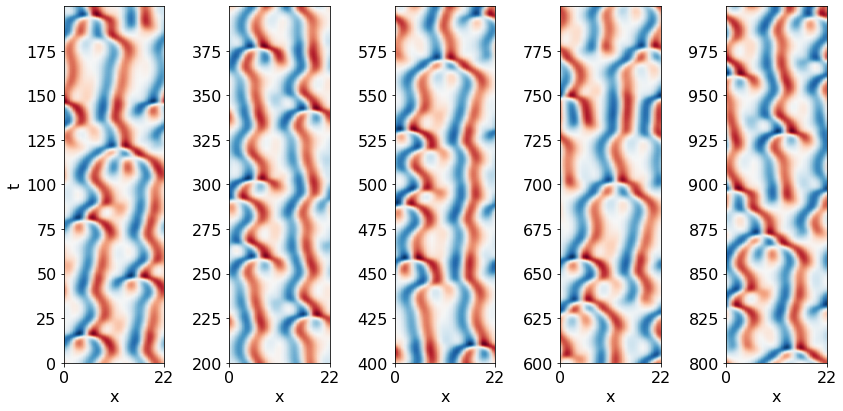

In [201]:
fig, axes = plt.subplots(1, 5, figsize=(12,6))

for k, ax in enumerate(axes):
    it_i = (len(tt) // len(axes)) * k
    it_f = (len(tt) // len(axes)) * (k+1)
    ks.plot_spacetime(sol[it_i:it_f:10], tt[it_i:it_f:10], ax=ax)
    ax.set_xticks([0, ks.L])
    if not(k==0):
        ax.set_ylabel('')
        
fig.tight_layout()

In [202]:
compl_sol = np.zeros((sol.shape[0], d//2), dtype=complex)
compl_sol[:, 0:d//2] = sol[:, 0:d:2] + 1j * sol[:, 1:d:2]

Text(0, 0.5, 'phase speed')

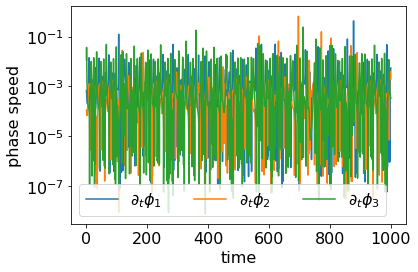

In [266]:
i = 0
f = 100000 - 1

phi_1 = np.unwrap(np.angle(compl_sol[i:f, 0]))
phi_2 = np.unwrap(np.angle(compl_sol[i:f, 1]))
phi_3 = np.unwrap(np.angle(compl_sol[i:f, 2]))

dt_phi_1 = phi_1[1:] - phi_1[:-1]
dt_phi_2 = phi_2[1:] - phi_2[:-1]
dt_phi_3 = phi_3[1:] - phi_3[:-1]



plt.semilogy(tt[i+1:f],np.sqrt(dt_phi_1**2), label='$\partial_t \phi_1$')
plt.semilogy(tt[i+1:f],np.sqrt(dt_phi_2**2), label='$\partial_t \phi_2$')
plt.semilogy(tt[i+1:f],np.sqrt(dt_phi_3**2), label='$\partial_t \phi_3$')
plt.legend(ncol=3)
plt.xlabel('time')
plt.ylabel('phase speed')

In [267]:
print(np.max(dt_phi_1 ** 2), np.max(dt_phi_2 ** 2), np.max(dt_phi_3 ** 2))
print(np.mean(dt_phi_1 ** 2), np.mean(dt_phi_2 ** 2), np.mean(dt_phi_3 ** 2))

0.181964332329459 0.42857393295447427 0.05746394243501653
2.2459455095585477e-05 2.0065148904322302e-05 3.345051229374613e-05


In [268]:
phihat_1 = (np.angle(compl_sol[:, 1]) - np.pi/2) / 2

In [269]:
compl_sol_ = compl_sol.copy()

for ik, k in enumerate(range(1,d//2+1)):
    compl_sol_[:, ik] *= np.exp(- 1j * k * phihat_1)

In [270]:
i_even_modes = np.arange(1, d//2, 2)
i_odd_modes = np.arange(0, d//2, 2) 

In [271]:
c = np.zeros(i_odd_modes.shape)
# c[0] = 1
# c[1] = 0
vhat_1 = compl_sol_[:, i_odd_modes[0]] 
vhat_3 = compl_sol_[:, i_odd_modes[1]] 


phipi_1 = np.unwrap(np.angle(vhat_1))
phipi_3 = np.unwrap(np.angle(vhat_3))


dt_phipi_1 = phipi_1[1:] - phipi_1[:-1]
dt_phipi_3 = phipi_3[1:] - phipi_3[:-1]

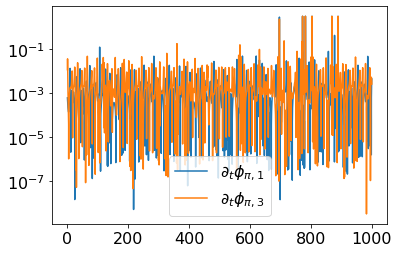

In [272]:
plt.semilogy(tt[i+1:f], np.sqrt(dt_phipi_1[i+1:f]**2), label='$\partial_t \phi_{\pi, 1}$')
plt.semilogy(tt[i+1:f], np.sqrt(dt_phipi_3[i+1:f]**2), label='$\partial_t \phi_{\pi, 3}$')
plt.legend(ncol=1)

In [273]:
compl_sol__ = compl_sol_.copy()
compl_sol__[:, i_odd_modes] *= np.exp(1j * phipi_1).reshape(compl_sol_.shape[0], 1)

In [274]:
def ref_mode_phase_speed(coefs, mean=False):
    
    compl_coefs = coefs[0::2] + 1j * coefs[1::2]
    
    compl_ref_modes = np.zeros((sol.shape[0], (ks.K-1) // 2), dtype=complex)
    compl_ref_modes[:, 0:len(i_even_modes[1:])] = (
        np.real(compl_sol__[:, i_even_modes[1:]])
        + 1j * np.imag(compl_sol__[:, i_odd_modes[0:len(i_even_modes[1:])]])
    )
    compl_ref_modes[:, -1] = (
        np.imag(compl_sol__[:, i_odd_modes[-2]]) 
        + 1j * np.imag(compl_sol__[:, i_odd_modes[-1]])
    )
    ref_mode = compl_ref_modes @ compl_coefs
    phase = np.unwrap(np.angle(ref_mode))
    phase_speed = (phase[1:] - phase[:-1]) ** 2
    
    if mean:
        return np.mean(phase_speed)
    else:
        return phase_speed

In [275]:
from scipy.optimize import minimize, NonlinearConstraint

In [276]:
# np.random.seed(42)
coefs_0 = np.random.randn(14)
coefs_0 /= np.linalg.norm(coefs_0)

opt = minimize(
    ref_mode_phase_speed, coefs_0, args=(True,), 
    constraints=NonlinearConstraint(np.linalg.norm, 1.0, 1.0)
)

In [277]:
opt_coefs = opt.x

In [278]:
opt_phase_speed = ref_mode_phase_speed(opt_coefs)

In [279]:
opt_coefs

array([-0.36908092, -0.0803293 ,  0.03378958,  0.24111884, -0.20621733,
       -0.06710926, -0.37474939, -0.40347013,  0.27125945,  0.44945116,
       -0.02393181,  0.33338325,  0.12029779, -0.21451253])

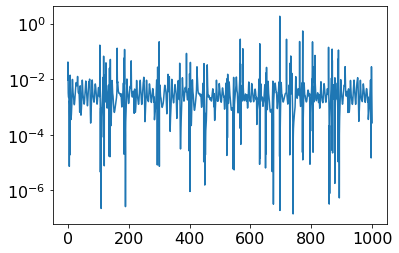

In [289]:
plt.semilogy(tt[i:f],np.sqrt(opt_phase_speed))

In [290]:
# np.savetxt("opt_coefs.dat", opt_coefs)
opt_coefs = np.loadtxt("opt_coefs.dat")

In [300]:
compl_red_sol.shape

(100000, 15)

In [307]:
compl_sol__[100, i_even_modes[0]]

(5.551115123125783e-17+0.5222774560571954j)

In [311]:
compl_red_sol = compl_sol__.copy()

compl_ref_modes = np.zeros((sol.shape[0], (ks.K-1) // 2), dtype=complex)
compl_inv_modes = np.zeros((sol.shape[0], (ks.K-1) // 2 + 1), dtype=complex)

# projecting the reflection-equvariant state vector into symm/antisymm subspaces

compl_inv_modes[:, 0] = compl_sol__[:, i_even_modes[0]]
compl_inv_modes[:, 1:1+len(i_even_modes[1:])] = (
    np.imag(compl_sol__[:, i_even_modes[1:]])
    + 1j * np.real(compl_sol__[:, i_odd_modes[0:len(i_even_modes[1:])]])
)
compl_inv_modes[:, -1] = (
    np.real(compl_sol__[:, i_odd_modes[-2]]) 
    + 1j * np.real(compl_sol__[:, i_odd_modes[-1]])
)

compl_ref_modes[:, 0:len(i_even_modes[1:])] = (
    np.real(compl_sol__[:, i_even_modes[1:]])
    + 1j * np.imag(compl_sol__[:, i_odd_modes[0:len(i_even_modes[1:])]])
)
compl_ref_modes[:, -1] = (
    np.imag(compl_sol__[:, i_odd_modes[-2]]) 
    + 1j * np.imag(compl_sol__[:, i_odd_modes[-1]])
)

coefs = opt_coefs[0::2] + 1j * opt_coefs[1::2]
symmred_mode = compl_ref_modes @ coefs
symmred_phase = np.angle(symmred_mode)

compl_red_sol[:, 0:(ks.K-1)//2+1] = compl_inv_modes
compl_red_sol[:, (ks.K-1)//2+1:] = (
    compl_ref_modes 
    * np.exp(1j * symmred_phase).reshape(compl_ref_modes.shape[0], 1)
)
red_sol = sol.copy()
red_sol[:, 0::2] = np.real(compl_red_sol)
red_sol[:, 1::2] = np.imag(compl_red_sol)

In [312]:
from sklearn.decomposition import PCA

In [314]:
pca = PCA(n_components=3)
pca.fit(red_sol)
proj = pca.transform(red_sol)

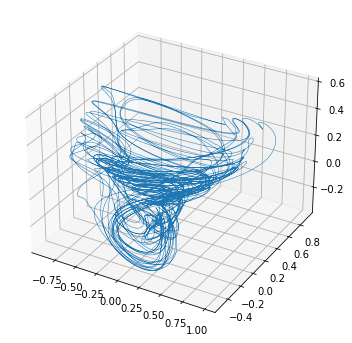

In [323]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], lw=0.5)